# German Greetings: Dialectology with Twitter

Dialectologists like to collect language samples from multiple locations
to investigate linguistic variation across space. Can we leverage Twitter for this purpose?

Here, I search Twitter for German tweets using either *"Moin"* - a greeting associated with
Northern Germany - and *"Servus"* - associated with the South.

In [ ]:
# crawl twitter for germans saying moin or servus and store the tweet's origin
# this code has to be run a while to collect a sufficient number of samples, e.g., a few hours
# for 100 samples.

import hashlib
from time import sleep
import TwitterSearch
import googlemaps
import pandas as pd

# create Twitter and Googlemaps API keys and store them in a file tokens.py
from tokens import (CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_SECRET,
                    GMAP_KEY)

ts = TwitterSearch.TwitterSearch(
    consumer_key = CONSUMER_KEY,
    consumer_secret = CONSUMER_SECRET,
    access_token = ACCESS_TOKEN,
    access_token_secret = ACCESS_SECRET
 )

gmaps = googlemaps.Client(key=GMAP_KEY)

def get_location(code):
    """Call the Googlemaps API to get long/lat coords for arbitrary strings"""
    try:
        geocode_result = gmaps.geocode(code)
        is_in_germany = any(
            [loc.get("long_name", "") == "Germany"
             for loc in geocode_result[0]["address_components"]])
        if is_in_germany:  # only return german locations
            location = geocode_result[0]['geometry']['location']
            lng, lat = location["lng"], location["lat"]
            if not (lat == 51.165691 and lng == 10.451526):  # Germany itself
                return lng, lat
        else:
            return
    except Exception:
        return

big_df = pd.read_csv("servusmoin.csv", index_col=0)
locs = dict()

words = ["moin", "servus"]

from random import choice
while True:
    """Collect Tweets; done in a while loop so we can interrupt it any time."""
    try:
        try:  # check if res exists, otherwise create it
            res
        except NameError:
            res = {k: list() for k in words}
        word = choice(words)  # select either word at random
        tso = TwitterSearch.TwitterSearchOrder()
        tso.set_keywords([word])
        tso.set_language('de') # we want to see German tweets only

        tweets = ts.search_tweets(tso)["content"]["statuses"]
        res[word] += [(tweet["text"], str(tweet["user"]["location"]))
                      for tweet in tweets if not tweet['retweeted']]
        del tweets
    except TwitterSearch.TwitterSearchException:
        print("Rate limited, doing maintenance and waiting 15 min ...")
        for word, tweets in res.items():  # store results in a csv
            for (text, loc) in tweets:
                if loc not in locs:  # fetch new locations from googlemaps
                    locs[loc] = loc_ = get_location(loc)
                else:
                    loc_ = locs[loc]  # known locations can simply be looked up
                if loc_ is not None:
                    hash_ = hashlib.md5(text.encode("utf-8")).hexdigest()
                    # hash the text and use it as index key to ignore dups
                    lng, lat = loc_
                    big_df.loc[hash_, "long"] = lng
                    big_df.loc[hash_, "lat"] = lat
                    big_df.loc[hash_, "word"] = word  # moin or servus?
        big_df.to_csv("servusmoin.csv")
        del res  # save a bit of RAM
        sleep((60 * 15))  # wait 15min until we can search again
        print("Enough waiting! Continuing.")


# Example Tweets

Above, we store only hashes, locations and the greeting in question.
But if you're curious, some example tweets I encountered looked like this (after removing `@`ded people, and adding locations):
    
    Fahrradfahrer sagen nie Moin. Solche Keks Deutschland

    Unterwegs mit anderen YouTubern | Fire of the Wolf &amp; Moin Dave | Let´s Play Kiel, Schleswig-Holstein

    moin, was möchtest du für ein User treff haben? 

    Moin. Spiele gerade eine neue Liverpool Karriere. Das erste Jahr ist gut verlaufen und wäre nun im Vor… Berlin 

    Da grübel ich, wieso die Markierungsstöckchen im Hochbeet ständig verschwinden und dann sehe ich sie: Die Amsel, in meinem H… 

    Wilhelmshaven - Moin Moin um 16:30 ich kann mich nicht daran gewöhnen 😎 Aachen, Deutschland

    Moin Mr Nielsen Germany

    Moin Moin, der Supertip 2018 ist offiziell eröffnet! Mail an uns mit dem gewünschten Tippernamen, dann schalten wir Euch frei!
    Glück auf! 

    ..ich lebe dort wo man auch am Abend Moin sagt...😉
    Hab noch einen schönen Abend..🍷😗 inner Mitte vonner Titte

    Moin,
    heute sind wir in mehrere Märkte eingestiegen, und einer davon ist SB Zucker.
    Einstieg 11,91   Stopp Loss…
   
Not perfect, but it will do.

# Prepare Data

Next, we load the collected data, and for each location, calculate the ratio between *moin* vs. *servus*,
and count the total number of tweets there.

In [1]:
df_summary = pd.read_csv("../tweets/servusmoin.csv", index_col=0)
df_summary["word"].value_counts()
df_summary["is_servus"] = df_summary["word"] == "servus"
df = df_summary.groupby(["lat", "long"]).mean()
df["count"] = df_summary.groupby(["lat", "long"]).count().sum(1)

# Plotting

Now we can plot the data with `Basemap`.
To distort the data itself as little as possible, I simply point disks at each location,
with the size of the disk showing the number of tweets from this location,
and the color showing the prevalence of servus vs. moin.

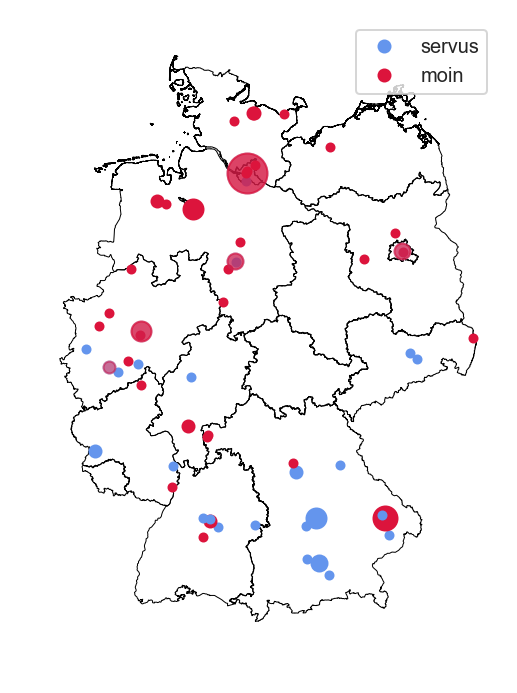

In [2]:
from mpl_toolkits.basemap import Basemap
west, east, south, north = 46.5, 55.5, 5, 15.5
m = Basemap(projection='merc', resolution='i',
            llcrnrlat=west, urcrnrlat=east, llcrnrlon=south, urcrnrlon=north)
m.readshapefile("..gadm36_DEU_1", "de")  # this is a map of Germany. download GADM maps here:
# https://gadm.org/download_country_v3.html

for long_, lat_ in df.index:
    ratio, count = df.loc[(long_, lat_), ["is_servus", "count"]]  # this is a bit convoluted
    m.plot(lat_,  long_,'o', markersize=2 + count,
           color='cornflowerblue', alpha=ratio, latlon=True)
    m.plot(lat_,  long_,'o', markersize=2 + count,
           color='crimson', alpha=1-ratio, latlon=True)  # using alpha is a lazy way of getting the color gradient

m.plot(0, 0, 'o', color='cornflowerblue', latlon=True, label="servus")
m.plot(0, 0, 'o', color='crimson', latlon=True, label="moin")  # off-plot to get the legend
ax = plt.gca()
ax.axis("off")
ax.legend(frameon=True);
plt.gcf().set_size_inches((8, 6))

Great! We see people in Hamburg (big red circle at the top) like to say *Moin*,
people in Bavaria like to say *Servus* (although some city dwellers in Bavaria also *moin* a bit).

We are also missing a few *Bundesländer* - people there would have to tweet more for this script
to pick it up in a reasonable time frame ...

But still, we can do rudimentary Twitter-based dialect linguistics in a few lines of Python code.